# GNN for Vote Prediction Only

This notebook trains a **Graph Neural Network (GraphSAGE)** to predict, for a pair *(voter u, candidate t)*:

- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`

## Setup

In [ ]:
# Import standard libraries
import sys
from pathlib import Path
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Computations
import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, train_val_test_split_by_date
from utility import analyze_split_statistics
from training import eval_polarity, train_polarity_only, FocalLoss
from gnn_embedding_model import HeteroPolarityGNN

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("DEVICE:", DEVICE)

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [2]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [3]:
# Encode users as numerical IDs
users = sorted(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('!---slappdash---!', np.int64(0)), ('%D0%90', np.int64(1)), ("'sed", np.int64(2)), ('(.Y.)', np.int64(3)), ('(:Julien:)', np.int64(4)), ('(aeropagitica)', np.int64(5)), ('*Kat*', np.int64(6)), ('*Spark*', np.int64(7)), ('*drew', np.int64(8)), ('-Midorihana-', np.int64(9))]


In [4]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {0,1,2}
y_pos = y + 1
print("Positive edges:", X.size(0))

Positive edges: 188816


## Train - Validation - Test split

This function divide the whole dataset in three parts based on the date. The outputs are ordered by date.

Training set shape: torch.Size([183356, 2]) between dates 20030816 and 20121004
Validation set shape: torch.Size([1621, 2]) between dates 20121005 and 20121204
Test set shape: torch.Size([3839, 2]) between dates 20121212 and 20130605

===================== DATASET SPLITTING ANALYSIS =====================

[1] Topology & Density (Graph Connectivity)
        Edges  Nodes Avg Degree
Split                          
Train  175446  10874      16.13
Val      1619    486       3.33
Test     3837    831       4.62

[2] User Overlap & Cold Start Diagnostics (Inductive vs Transductive)


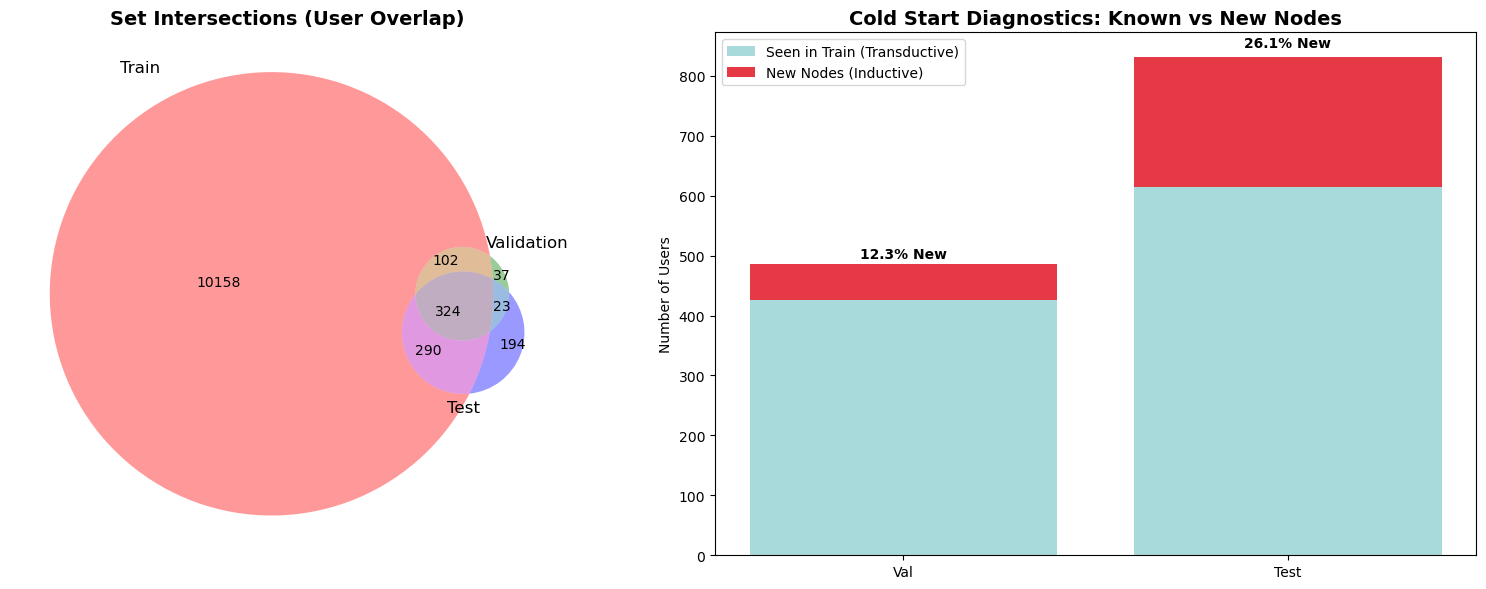


[3] Edge Duplicates Analysis
Found 19 duplicate edges between Train-Val
Found 102 duplicate edges between Train-Test
Found 0 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


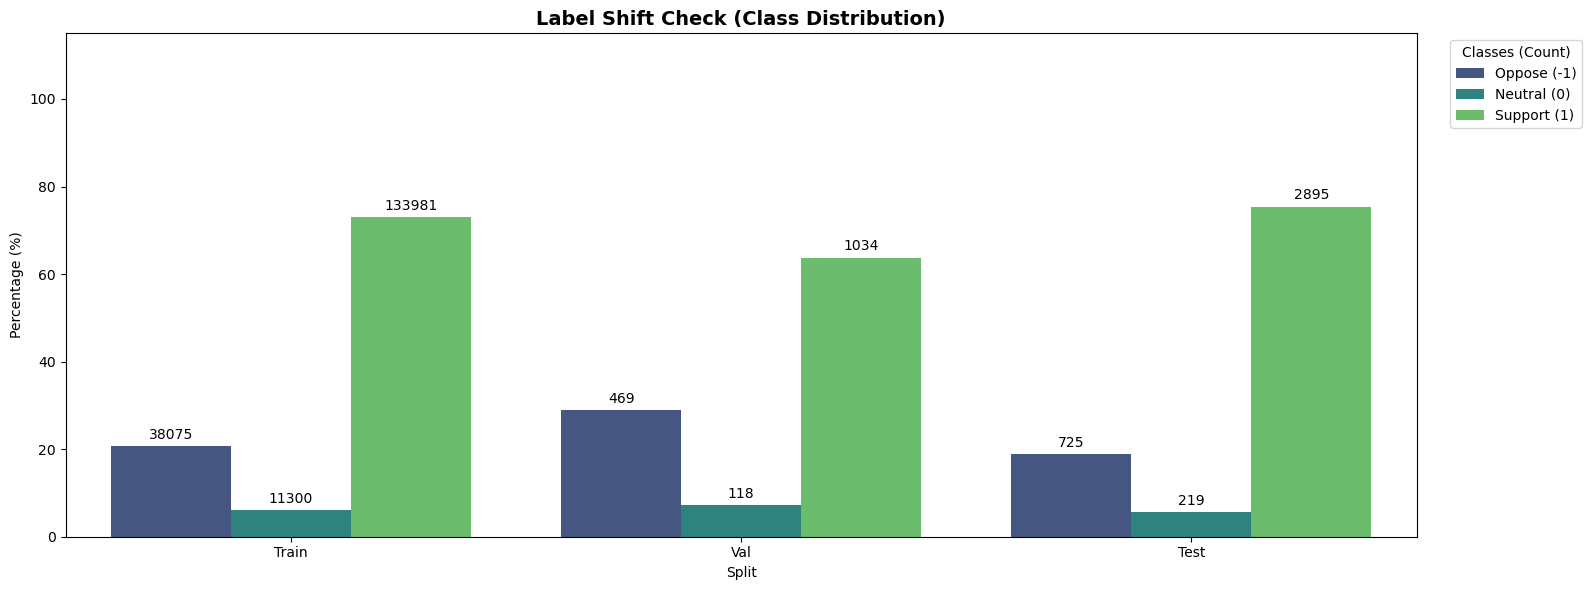

In [5]:
(X_tr, y_tr, dates_tr), (X_val, y_val, dates_val), (X_test, y_test, dates_test) = train_val_test_split_by_date(X, y_pos, dates, val_months=2, test_months=6)

# Splits summary
print(f"Training set shape: {X_tr.shape} between dates {dates_tr.min()} and {dates_tr.max()}")
print(f"Validation set shape: {X_val.shape} between dates {dates_val.min()} and {dates_val.max()}")
print(f"Test set shape: {X_test.shape} between dates {dates_test.min()} and {dates_test.max()}")

analyze_split_statistics(X_tr, y_tr, X_val, y_val, X_test, y_test)

## Data structure creation

In [ ]:
num_users = len(user_map)

# Message-passing graph 
edge_index = X.t().contiguous()  # [2, E_train_pos]

# Filling features
x_features = torch.zeros((num_users, 0), dtype=torch.float)

# HeteroData
data = HeteroData()
data['user'].x = x_features

data['user', 'votes', 'user'].edge_index = edge_index
data['user', 'rev_votes', 'user'].edge_index = edge_index.flip(0)

data = data.to(DEVICE)

print(data)

HeteroData(
  user={ x=[11128, 0] },
  (user, votes, user)={ edge_index=[2, 188816] },
  (user, rev_votes, user)={ edge_index=[2, 188816] }
)


## Class weights

In [ ]:
# Polarity labels from positives only
alpha = 0.5
pol_counts = torch.bincount(y_tr, minlength=3).float()
pol_base_w = pol_counts.sum() / pol_counts
pol_weights = pol_base_w.pow(alpha).to(DEVICE)

print("Train polarity counts [Oppose, Neutral, Support]:", pol_counts.tolist())
print("Polarity weights:", pol_weights.tolist())

Train polarity counts [Oppose, Neutral, Support]: [38075.0, 11300.0, 133981.0]
Polarity weights: [2.1944596767425537, 4.028174877166748, 1.1698386669158936]


## Neighbor-sampled loaders

Create LinkNeighborLoader objects to train on mini-batches using sampled subgraphs.

In [8]:
edge_type = ('user', 'votes', 'user')

def add_edge_label_to_batch(batch):
    # Copy labels to top-level attribute for convenience
    if hasattr(batch[edge_type], 'edge_label'):
        batch.edge_label = batch[edge_type].edge_label
    return batch

train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=(edge_type, X_tr.t().contiguous()),
    edge_label=y_tr,
    batch_size=2048,
    shuffle=True,
    transform=add_edge_label_to_batch
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=(edge_type, X_val.t().contiguous()),
    edge_label=y_val,
    batch_size=4096,
    shuffle=False,
    transform=add_edge_label_to_batch
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=(edge_type, X_test.t().contiguous()),
    edge_label=y_test,
    batch_size=4096,
    shuffle=False,
    transform=add_edge_label_to_batch
)

## Training

Train the model with weighted cross-entropy and early stopping on validation macro-F1.

In [ ]:
ckpt_path = "checkpoints/votegnn_best.pt"

model = HeteroPolarityGNN(
    metadata=data.metadata(),
    num_users=num_users,
    emb_dim=64,
    hidden_dim=128,
    dropout=0.2
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

loss = FocalLoss(weight=pol_weights, gamma=1.0)

# loss = nn.CrossEntropyLoss(weight=pol_weights)

model = train_polarity_only(
    model, optimizer, loss,
    train_loader, val_loader,
    device=DEVICE,
    patience=8,
    num_epochs=50,
    checkpoint_path=ckpt_path,
)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Epoch 00 | Loss(avg): 1.2116 | Val macro-F1: 0.3343
Epoch 01 | Loss(avg): 1.1355 | Val macro-F1: 0.3735
Epoch 02 | Loss(avg): 1.0668 | Val macro-F1: 0.3831
Epoch 03 | Loss(avg): 1.0222 | Val macro-F1: 0.3943
Epoch 04 | Loss(avg): 0.9934 | Val macro-F1: 0.4196
Epoch 05 | Loss(avg): 0.9717 | Val macro-F1: 0.4286
Epoch 06 | Loss(avg): 0.9537 | Val macro-F1: 0.4259
Epoch 07 | Loss(avg): 0.9382 | Val macro-F1: 0.4254
Epoch 08 | Loss(avg): 0.9277 | Val macro-F1: 0.4490
Epoch 09 | Loss(avg): 0.9097 | Val macro-F1: 0.4344
Epoch 10 | Loss(avg): 0.9040 | Val macro-F1: 0.4617
Epoch 11 | Loss(avg): 0.8939 | Val macro-F1: 0.4686
Epoch 12 | Loss(avg): 0.8831 | Val macro-F1: 0.4657
Epoch 13 | Loss(avg): 0.8739 | Val macro-F1: 0.4895
Epoch 14 | Loss(avg): 0.8640 | Val macro-F1: 0.4620
Epoch 15 | Loss(avg): 0.8598 | Val macro-F1: 0.4720
Epoch 16 | Loss(avg): 0.8510 | Val macro-F1: 0.4760
Epoch 17 | Loss(avg): 0.8420 | Val macro-F1: 0.5020
Epoch 18 | Loss(avg): 0.8318 | Val macro-F1: 0.4893
Epoch 19 | L

In [ ]:
# Test evaluation
test_f1, (y_true, y_pred), report = eval_polarity(model, test_loader, DEVICE, report=True)

print(f"Test polarity macro-F1 on TP edges: {test_f1:.4f}")
print("\nVote polarity report on true-positive links:")
print(report if report is not None else "No TP edges predicted as Voted.")

Test polarity macro-F1 on TP edges: 0.4221

Vote polarity report on true-positive links:
              precision    recall  f1-score   support

      Oppose       0.30      0.46      0.36       725
     Neutral       0.13      0.19      0.15       219
     Support       0.83      0.69      0.75      2895

    accuracy                           0.62      3839
   macro avg       0.42      0.45      0.42      3839
weighted avg       0.69      0.62      0.64      3839



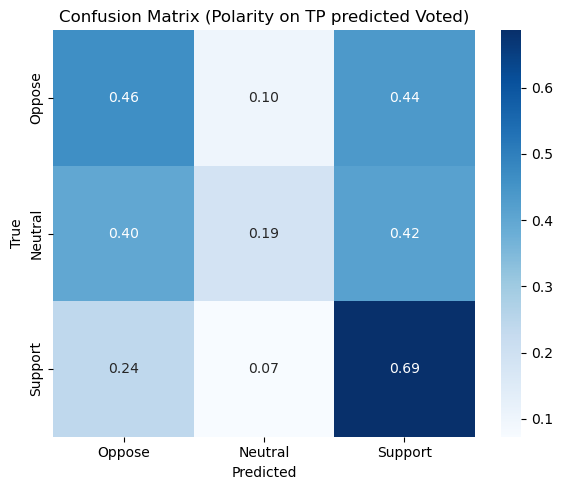

In [11]:
def plot_cm(cm, labels, title, normalize=False):
    if normalize:
        cm_plot = cm.astype(float)
        cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        cm_plot = cm.astype(int) 
        fmt = "d"

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Polarity confusion matrix on TP edges where model predicts Voted
cm_pol = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix (Polarity on TP predicted Voted)", normalize=True)